2025-04-11 21:39:33,555 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-0.926
2025-04-11 21:54:19,067 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9263322884012539, best pos: [93.23040957  0.65115801  0.47063129  1.50868197  0.24773994]


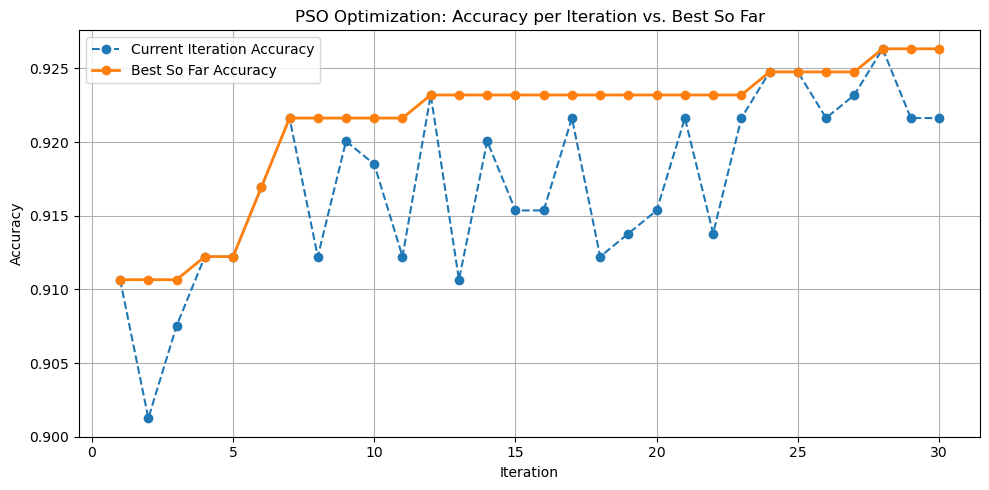

=== PSO + MLP Optimization Summary ===
Best Test Accuracy: 0.9263
Best Hidden Layer Size: (93,)
Best Learning Rate Init: 0.6512
Best Alpha: 0.4706
Best Activation: tanh
Best Solver: lbfgs
Total Attempts: 450
Search Dimensions: 5
Wall Time (s): 885.52


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from pyswarms.single import GlobalBestPSO
from ucimlrepo import fetch_ucirepo

# Silence convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load and preprocess dataset
dataset = fetch_ucirepo(id=69)  # Gene splicing dataset
X_raw = dataset.data.features
y_raw = dataset.data.targets
X = OrdinalEncoder().fit_transform(X_raw)
y = LabelEncoder().fit_transform(y_raw.values.ravel())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define wide search space for MLP hyperparameters
activation_options = ['identity', 'logistic', 'tanh', 'relu']
solver_options = ['lbfgs', 'sgd', 'adam']
lb = [5, 1e-4, 1e-6, 0, 0]
ub = [200, 1.0, 1.0, 3, 2]
bounds = (np.array(lb), np.array(ub))

# Accuracy tracking (history & cumulative best)
accuracy_history = []
best_so_far_history = []

# Objective function (no CV)
def objective_mlp(swarm):
    results = []
    global accuracy_history, best_so_far_history
    for params in swarm:
        try:
            hidden_layer_sizes = (int(round(params[0])),)
            learning_rate_init = float(params[1])
            alpha = float(params[2])
            activation = activation_options[int(round(params[3]))]
            solver = solver_options[int(round(params[4]))]

            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                learning_rate_init=learning_rate_init,
                alpha=alpha,
                activation=activation,
                solver=solver,
                max_iter=500,
                random_state=42
            )
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            results.append(-acc)

        except:
            results.append(1.0)

    best_acc = -min(results)
    accuracy_history.append(best_acc)
    # Track historical best so far (cumulative max)
    if best_so_far_history:
        best_so_far_history.append(max(best_acc, best_so_far_history[-1]))
    else:
        best_so_far_history.append(best_acc)
    return np.array(results)

# Run PSO
start_time = time.time()
n_particles = 15
max_iter = 30
optimizer = GlobalBestPSO(
    n_particles=n_particles,
    dimensions=5,
    options={'c1': 1.5, 'c2': 1.5, 'w': 0.5},
    bounds=bounds
)
cost, best_pos = optimizer.optimize(objective_mlp, iters=max_iter)
end_time = time.time()

# Decode best parameters
best_hidden = (int(round(best_pos[0])),)
best_lr = float(best_pos[1])
best_alpha = float(best_pos[2])
best_activation = activation_options[int(round(best_pos[3]))]
best_solver = solver_options[int(round(best_pos[4]))]

# Final model
model = MLPClassifier(
    hidden_layer_sizes=best_hidden,
    learning_rate_init=best_lr,
    alpha=best_alpha,
    activation=best_activation,
    solver=best_solver,
    max_iter=500,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

# Plot: cumulative best accuracy (monotonic increasing)
# Plot both raw accuracy and best-so-far accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history)+1), accuracy_history, marker='o', label="Current Iteration Accuracy", linestyle='--')
plt.plot(range(1, len(best_so_far_history)+1), best_so_far_history, marker='o', label="Best So Far Accuracy", linewidth=2)
plt.title("PSO Optimization: Accuracy per Iteration vs. Best So Far")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Output summary
# Output summary (rounded to 4 digits where appropriate)
metrics = {
    'Best Test Accuracy': round(final_accuracy, 4),
    'Best Hidden Layer Size': best_hidden,
    'Best Learning Rate Init': round(best_lr, 4),
    'Best Alpha': round(best_alpha, 4),
    'Best Activation': best_activation,
    'Best Solver': best_solver,
    'Total Attempts': n_particles * max_iter,
    'Search Dimensions': 5,
    'Wall Time (s)': round(end_time - start_time, 2)
}
print("=== PSO + MLP Optimization Summary ===")
for k, v in metrics.items():
    print(f"{k}: {v}")

